# Brief

# Veille

Question de veilles:

Qu'est ce que le clustering ? Est ce un probleme difficile ? pourquoi ?

    - qu'elle est la compléxité d'un probléme de clustering ? 
    - Quelle sont les métrique utilisé pour le clustering ?
    - Ecriver en une phrase votre comprhéension pour chaque métrique découverte
    - séparer les métrique avec "ground truth" et "sans "ground truth".
    - différenc entre NMI et AMI ?


Introducing k-Means

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

   - The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
   - Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model.

In [ ]:
Qu'est ce que le clustering ? Est ce un probleme difficile ? pourquoi ?

Il existe deux types de clustering :

    Le clustering hiérarchique
    Le clustering non-hiérarchique (partitionnement)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
#loading the digits
from sklearn.datasets import load_digits
digits = load_digits()
print ("The digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image :" ,digits.data.shape)


The digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image : (1797, 64)


In [3]:
#inding the KMeans clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

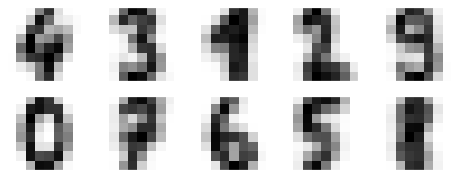

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:


In [5]:
#matching each learned cluster label with the true labels found in them :

from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [6]:
#Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

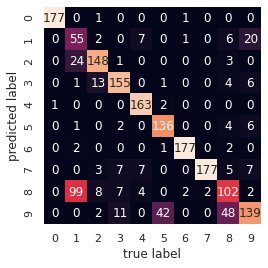

In [7]:
#With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let's check
#the confusion matrix for this:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, 
we can essentially build a digit classifier without reference to any known labels!

Just for fun, let's try to push this even farther. We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in In-Depth: Manifold Learning) to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [8]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

That's nearly 93% classification accuracy without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

# PCA with scatter

In [9]:
#PCA with tsne data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_tsne=pca.fit(digits_proj)

print(pca_tsne.explained_variance_ratio_)
print (pca_tsne.singular_values_)

[0.59324676 0.40675327]
[1465.1588 1213.2004]


In [10]:
#PCA on original datas
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scale(digits.data))

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.12033916 0.09561054]
[114.85302699 102.37451345]


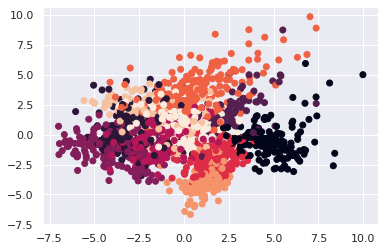

In [26]:
# Matplolib Datas visualisation with original datas


plt.scatter(pca_data[:,0], pca_data[:,1], c= clusters)


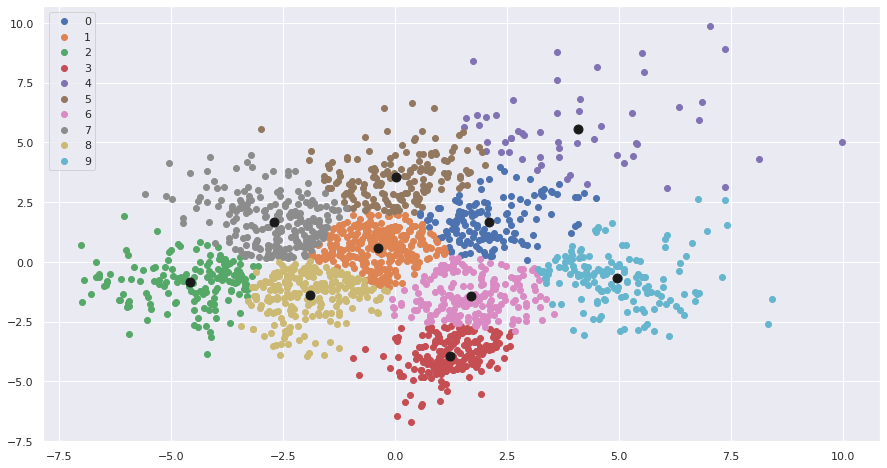

In [27]:
# Plotly Datas visualisation with original datas

model2 = kmeans.fit_predict(pca_data)

centroids = kmeans.cluster_centers_
unique_labels = np.unique (model2)

# plot 

fig = plt.figure (1, figsize=(15,8))
for i in unique_labels :
    plt.scatter(pca_data[model2  == i , 0 ], pca_data [model2  == i , 1], label = i)

plt.scatter(centroids[:,0], centroids [:,1], s=80, color = 'k')
plt.legend()
plt.show()

# PCA with Pipeline

In [28]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print( f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [29]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(kmeans, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]

    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    # The silhouette score requires the full dataset
    results += [ metrics.silhouette_score(data, estimator[-1].labels_, metric="euclidean", sample_size=300,) ]
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)

bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.319s	69485	0.613	0.660	0.636	0.482	0.632	0.136
random   	0.162s	69952	0.545	0.616	0.578	0.415	0.574	0.125
PCA-based	0.065s	72686	0.636	0.658	0.647	0.521	0.643	0.150
__________________________________________________________________________________


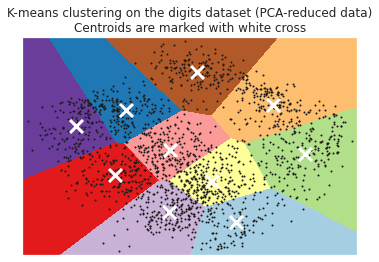

In [31]:
#Visualize the results on PCA-reduced data
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()